Construct a model for scoring
-----------------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
import shap
from shap import TreeExplainer, summary_plot
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.metrics import roc_auc_score
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import fbeta_score, make_scorer

/Users/sanjibansantra/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### I import the csv file

In [2]:
df=pd.read_csv('home-credit-default-risk/application_train.csv', sep =',')

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [5]:
df.shape

(307511, 122)

In [6]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### We perform some EDA 

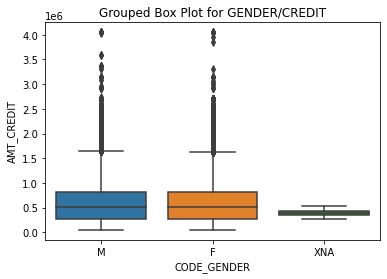

In [7]:
sns.boxplot(x='CODE_GENDER', y='AMT_CREDIT', data=df).set_title('Grouped Box Plot for GENDER/CREDIT');

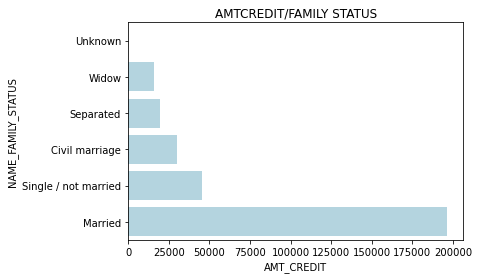

In [8]:
res = df.groupby(['NAME_FAMILY_STATUS'])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')
ax=sns.barplot(x='AMT_CREDIT', y='NAME_FAMILY_STATUS', color='lightblue', data=res).set_title('AMTCREDIT/FAMILY STATUS');

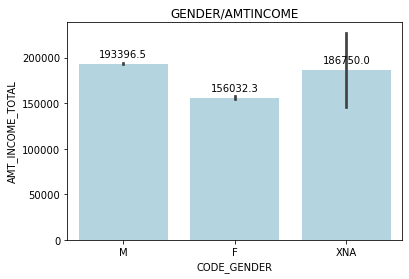

In [9]:
g= sns.barplot(x='CODE_GENDER', y='AMT_INCOME_TOTAL', color='lightblue', data=df)
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    g.set_title('GENDER/AMTINCOME')

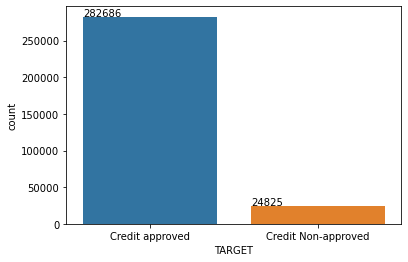

In [10]:
s = sns.countplot(x = 'TARGET',data = df)
for p in s.patches:
    s.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    s.set_xticklabels(['Credit approved','Credit Non-approved']);

0 means actually the credit is given and 1 means the credit is rejected.

In [11]:
r1 = df.groupby(['CNT_CHILDREN'])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')

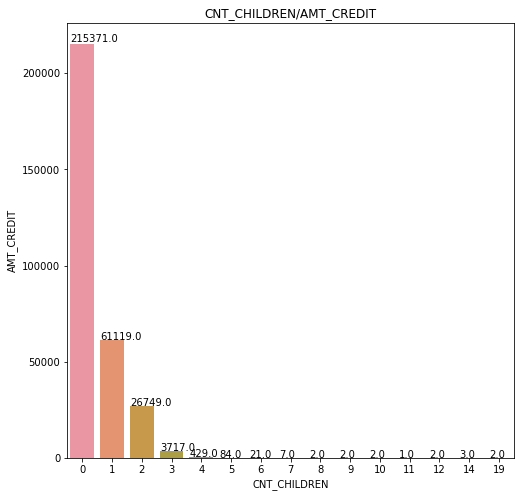

In [12]:
plt.figure(figsize=(8, 8))
s = sns.barplot(x='CNT_CHILDREN', y='AMT_CREDIT', data=r1)
for p in s.patches:
    s.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.title("CNT_CHILDREN/AMT_CREDIT")

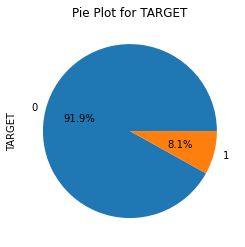

In [13]:
df['TARGET'].value_counts().plot.pie(center=(0, 0), radius=1.0, autopct='%1.1f%%').set_title('Pie Plot for TARGET');

### The data is imbalanced

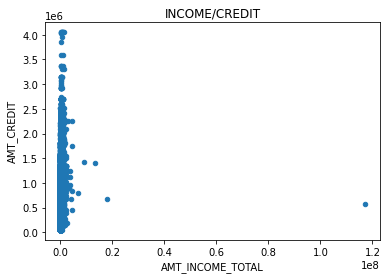

In [14]:
df.plot(kind = 'scatter', x="AMT_INCOME_TOTAL", y="AMT_CREDIT", title="INCOME/CREDIT");

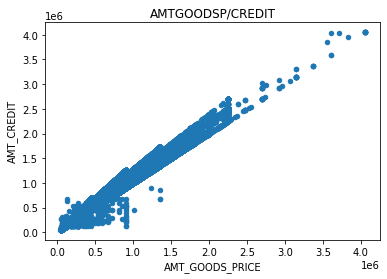

In [15]:
df.plot(kind = 'scatter', x="AMT_GOODS_PRICE", y="AMT_CREDIT", title="AMTGOODSP/CREDIT");

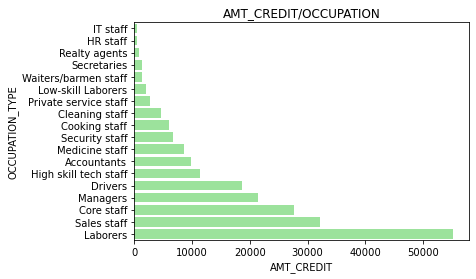

In [16]:
result = df.groupby(["OCCUPATION_TYPE"])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')
sns.barplot(x='AMT_CREDIT', y='OCCUPATION_TYPE', color='lightgreen', data=result)
plt.title("AMT_CREDIT/OCCUPATION");

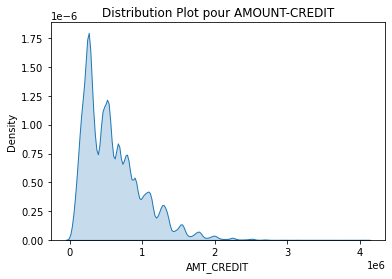

In [17]:
sns.kdeplot(df['AMT_CREDIT'], fill=True).set_title('Distribution Plot pour AMOUNT-CREDIT');

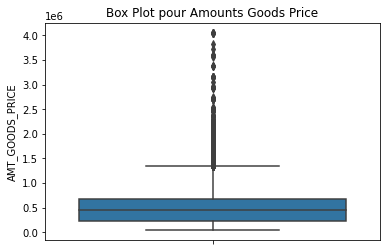

In [18]:
sns.boxplot(y='AMT_GOODS_PRICE', data=df).set_title('Box Plot pour Amounts Goods Price');

In [19]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [20]:
X1=df.select_dtypes('object')

In [21]:
X1.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [22]:
X1['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [23]:
X1.isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [24]:
X1= X1.drop(columns=['FONDKAPREMONT_MODE','HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'])

In [25]:
X1.isnull().sum()

NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
NAME_TYPE_SUITE                1292
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
OCCUPATION_TYPE               96391
WEEKDAY_APPR_PROCESS_START        0
ORGANIZATION_TYPE                 0
dtype: int64

In [26]:
df['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [27]:
col=['OCCUPATION_TYPE', 'NAME_TYPE_SUITE']
for x in col:
    X1[x]=X1[x].fillna(X1[x].mode()[0])

In [28]:
X1.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [29]:
X1.shape

(307511, 12)

In [30]:
X2 = df._get_numeric_data()

In [31]:
X2.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [32]:
X2.shape

(307511, 106)

In [33]:
#X2[X2['AMT_REQ_CREDIT_BUREAU_QRT'].isnull() == True]

In [34]:
X2 = X2.drop(columns=['REG_REGION_NOT_LIVE_REGION', 
                      'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
                      'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                      'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 
                      'EXT_SOURCE_2','EXT_SOURCE_3', 'APARTMENTS_AVG', 
                      'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
                      'YEARS_BUILD_AVG', 'COMMONAREA_AVG','ELEVATORS_AVG', 
                      'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 
                      'LIVINGAPARTMENTS_AVG'])

In [35]:
X2.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       

In [36]:
col=['DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'AMT_GOODS_PRICE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'BASEMENTAREA_MODE', 'LANDAREA_MODE', 'LANDAREA_MEDI',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'OWN_CAR_AGE', 'NONLIVINGAPARTMENTS_AVG',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'ELEVATORS_MEDI', 'NONLIVINGAREA_MEDI',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'BASEMENTAREA_MEDI',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'APARTMENTS_MODE', 
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'APARTMENTS_MEDI', 'ELEVATORS_MODE', 'TOTALAREA_MODE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'LIVINGAREA_AVG',
     'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'AMT_ANNUITY',
     'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'COMMONAREA_MODE', 'COMMONAREA_MEDI',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'CNT_FAM_MEMBERS']
for x in col:
    X2[x]=X2[x].fillna(X2[x].mean())

In [37]:
X2.isnull().mean().sort_values()

SK_ID_CURR                    0.0
FLAG_DOCUMENT_3               0.0
FLAG_DOCUMENT_2               0.0
DAYS_LAST_PHONE_CHANGE        0.0
DEF_60_CNT_SOCIAL_CIRCLE      0.0
                             ... 
NONLIVINGAREA_AVG             0.0
NONLIVINGAPARTMENTS_AVG       0.0
LIVINGAREA_AVG                0.0
ELEVATORS_MODE                0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 86, dtype: float64

### Now we concate the two dataframes

In [38]:
X = pd.concat([X1, X2], axis=1, join="inner")

In [39]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


In [40]:
X.shape

(307511, 98)

In [41]:
X.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

### Use label encoder to change category into numbers 

In [42]:
le = LabelEncoder()
col=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE']
for x in col:
    le.fit(X[x].astype(str))
    X[x] = le.transform(X[x].astype(str))

### Use One hot encoding on the remaining categorical data

In [43]:
X=pd.get_dummies(X, dummy_na=True)

In [44]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,ORGANIZATION_TYPE,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan
0,0,1,0,1,5,100002,1,0,202500.0,406597.5,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,39,100003,0,0,270000.0,1293502.5,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,1,11,100004,0,0,67500.0,135000.0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,5,100006,0,0,135000.0,312682.5,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,1,37,100007,0,0,121500.0,513000.0,...,0,0,0,0,0,0,1,0,0,0


### Create three new columns

In [45]:
X['NEW_DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
X['NEW_INCOME_CREDIT'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
X['NEW_INCOME_PER_PERSON'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']

In [46]:
X.shape

(307511, 158)

In [47]:
#X2=X.drop(columns=['NEW_INCOME_CREDIT', 'NEW_INCOME_PER_PERSON', 'NEW_DAYS_EMPLOYED'])

In [48]:
df1 = X[X['TARGET']==1] 
len(df1)

24825

In [49]:
df0 = X[X['TARGET']==0] 
len(df0)

282686

Now we create a dataframe which does not have the TARGET variable. We also drop some more column which we think is not required

In [50]:
A = X.drop(columns=['TARGET','FLAG_DOCUMENT_2', 'SK_ID_CURR',
                     'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                     'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                     'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
                     'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
                     'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 
                     'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'])

In [51]:
B = X['TARGET']

#### Featuring Engineering

In [52]:
model = XGBClassifier(eval_metric='logloss')
model.fit(A, B)
# feature importance
print(model.feature_importances_)

[0.01761853 0.02664059 0.02048638 0.00519954 0.00585541 0.00466757
 0.0056514  0.01147892 0.01000888 0.01534085 0.00698659 0.01215005
 0.01289231 0.00611037 0.00758803 0.01009677 0.         0.
 0.00985141 0.00501033 0.00778228 0.00383289 0.00652744 0.01381987
 0.02615891 0.00646918 0.00588789 0.00416348 0.00527179 0.00607335
 0.00532613 0.00894048 0.00460687 0.00575067 0.00576964 0.00517968
 0.00531683 0.00459977 0.00557772 0.00583012 0.00582495 0.00585819
 0.00573367 0.00617511 0.00547844 0.00640809 0.00557115 0.00527971
 0.0060856  0.00657007 0.01327514 0.00486456 0.00596181 0.00617146
 0.00462984 0.00578861 0.0057144  0.00622275 0.00521324 0.01205786
 0.00582671 0.00691162 0.00901111 0.0079191  0.00892673 0.00485253
 0.00458809 0.00711826 0.00750049 0.00572514 0.00591135 0.
 0.0029904  0.00337837 0.00539596 0.00538993 0.         0.
 0.00494358 0.         0.         0.01351891 0.         0.00754763
 0.05093664 0.         0.00356224 0.06631199 0.01119837 0.00788574
 0.03719136 0.     

<AxesSubplot:>

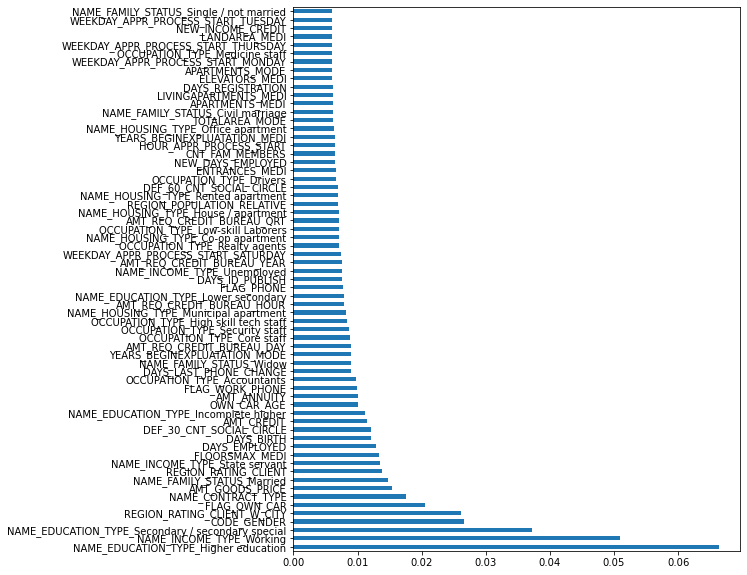

In [53]:
feat_imp = pd.Series(model.feature_importances_, index=A.columns)
feat_imp.nlargest(65).plot(kind='barh', figsize=(8,10));

In [54]:
unwanted = []
for col in A.columns:
    if col not in feat_imp.nlargest(65):
        unwanted.append(col)
A.drop(columns=unwanted,inplace=True)
A.sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,NEW_DAYS_EMPLOYED,NEW_INCOME_CREDIT
209940,1,0,0,180000.0,9000.0,180000.0,0.018850,-19250,-984,-5381.0,...,0,0,0,0,1,0,0,0,0.051117,0.300000
14735,0,0,0,384048.0,18031.5,270000.0,0.019101,-18515,-7550,-10081.0,...,0,0,0,0,0,0,0,0,0.407777,0.468691
209722,0,0,0,1215000.0,38839.5,1215000.0,0.011657,-18036,365243,-8890.0,...,0,0,0,0,0,0,0,0,-20.250776,0.051852
49745,1,0,0,315000.0,15750.0,315000.0,0.010032,-16676,-1190,-10605.0,...,0,0,0,0,0,0,1,0,0.071360,0.328571
188103,0,1,1,1006920.0,42790.5,900000.0,0.008625,-22215,-5515,-5180.0,...,0,0,0,0,0,0,0,0,0.248256,0.170719
147099,0,0,1,639000.0,24889.5,639000.0,0.018209,-12559,-1897,-3106.0,...,0,0,0,0,0,0,0,1,0.151047,0.357042
283800,0,0,0,134775.0,10935.0,112500.0,0.031329,-14661,-1538,-5060.0,...,0,0,0,0,0,0,0,1,0.104904,0.734558
117143,0,0,0,808650.0,23175.0,675000.0,0.010556,-18702,-1818,-4291.0,...,0,0,0,0,0,0,0,1,0.097209,0.111297
290258,0,1,1,679500.0,19998.0,679500.0,0.020713,-21672,-794,-8055.0,...,0,0,0,0,1,0,0,0,0.036637,0.099338
126096,0,0,0,225000.0,21919.5,225000.0,0.028663,-24578,365243,-8012.0,...,0,0,0,0,0,0,0,0,-14.860566,0.400000


In [55]:
A.shape

(307511, 65)

In [56]:
A.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'APARTMENTS_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'APARTMENTS_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'TOTALAREA_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Unemployed',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher educati

In [57]:
A.corr().shape[0]

65

In [58]:
# Create correlation matrix
corr_matrix = A.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
A.drop(to_drop, axis=1, inplace=True)

In [59]:
A.shape

(307511, 60)

In [60]:
A.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'APARTMENTS_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'TOTALAREA_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Unemployed',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDU

In [61]:
A1=A.drop(columns=['NEW_INCOME_CREDIT'])

In [62]:
#A1 = pd.concat([A, C], axis=1, join="inner")
#A1.shape

In [63]:
#len(A)

In [64]:
#plt.subplots(figsize=(20,15))
#sns.heatmap(A.corr(), annot = True)

In [65]:
#A2 = A1.drop(columns=['NEW_INCOME_CREDIT', 'NEW_INCOME_PER_PERSON'])

In [66]:
#A2.shape

### Since the data is too big we use down-sampling to balanced the data

In [67]:
nm = NearMiss()
X, y=nm.fit_sample(A, B)

In [68]:
X.shape, y.shape

((49650, 60), (49650,))

In [69]:
#nm = NearMiss()
#X, y=nm.fit_sample(A1, B)

In [70]:
#X.shape, y.shape

### Oversampling the data

In [71]:
#smote = SMOTE()
#X, y=smote.fit_sample(A, B)

In [72]:
#X.shape,y.shape

### Machine Learning Test Split Algorithm

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [74]:
X_train.shape

(39720, 60)

In [75]:
X_test.shape

(9930, 60)

In [76]:
col_names = X_train.columns
features = X_train[col_names]

### Use Standard scaler

In [77]:
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

In [78]:
X_train = scaled_features

In [79]:
colt_names = X_test.columns
feature = X_test[colt_names]

In [80]:
scaler = StandardScaler().fit(feature.values)
feature = scaler.transform(feature.values)
scale_feature = pd.DataFrame(feature, columns = colt_names)

In [81]:
X_test = scale_feature

In [82]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [83]:
#X_train=pd.DataFrame(X_train)
#X_test = pd.DataFrame(X_test)

In [84]:
X_test.shape, X_train.shape

((9930, 60), (39720, 60))

### Multiple Classifier Testing

In [85]:
models = [
    "KNearest_Neighbors", "Linear_SVM", "Gradient_Boosting", 
    "Decision_Tree", "Random_Forest", "AdaBoost", 
    "LogisticRegression"
         ]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    LogisticRegression(penalty = 'l2', C=5, random_state = 0)]

In [86]:
scores = []
f2_score = []
recall=[] 

for name, clf in zip(models, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    Recall=recall_score(y_test, y_pred)
    score = clf.score(X_test, y_test)
    scores.append(score)
    f2_score.append(f2)
    recall.append(Recall)

In [87]:
df = pd.DataFrame()
df['model'] = models
df['score'] = scores
df['f2_score'] = f2_score
df['Recall'] = recall
df =round(df, 4)

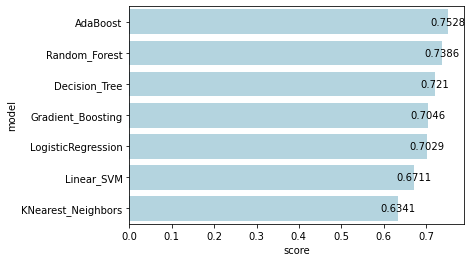

In [88]:
ax=sns.barplot(x="score",y="model",color='lightblue', data=df, order=df.sort_values('score', ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")

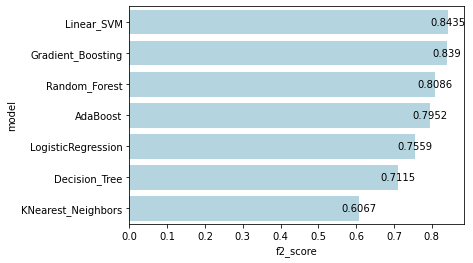

In [89]:
ax=sns.barplot(x="f2_score",y="model",color='lightblue', data=df, order=df.sort_values('f2_score',ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")

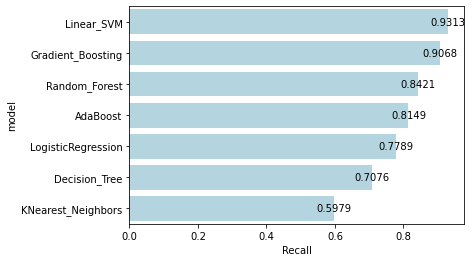

In [90]:
ax=sns.barplot(x="Recall",y="model",color='lightblue', data=df, order=df.sort_values('Recall',ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")

### Thus LINEAR SVM  gives the best Recall

### Multiple Classifier Testing using GridSearchCV

In [91]:
f2 = make_scorer(fbeta_score, beta=2, average='macro')

In [92]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [90,100,110]
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'criterion':['gini', 'entropy'],
            'max_depth': range (1,5)
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params' : {
            'n_neighbors':[4,5,6,7],
            'algorithm':['auto', 'kd_tree']
        }
    },
    'Adaboost': {
        'model': AdaBoostClassifier(),
        'params' : {
            'n_estimators': [50, 100],
            'learning_rate':[1.0]
        }
    },
    'Gradient_Boosting': {
        'model': GradientBoostingClassifier(),
        'params' : {
            'n_estimators': [100, 150],
            'learning_rate':[1.0]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

In [93]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring=f2, cv=5, return_train_score=False)
    clf.fit(X_test, y_test)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.711019,"{'C': 1, 'kernel': 'rbf'}"
1,random_forest,0.774947,{'n_estimators': 90}
2,decision_tree,0.685029,"{'criterion': 'gini', 'max_depth': 4}"
3,KNeighbors,0.642100,"{'algorithm': 'auto', 'n_neighbors': 7}"
4,Adaboost,0.776799,"{'learning_rate': 1.0, 'n_estimators': 100}"
5,Gradient_Boosting,0.797009,"{'learning_rate': 1.0, 'n_estimators': 100}"
6,logistic_regression,0.699260,{'C': 1}


### Hyperparameter tuning of Decision Tree Classifier Using GridSearchCV

In [94]:
DTree = DecisionTreeClassifier()
DTree.fit(X_train, y_train)

DecisionTreeClassifier()

In [95]:
params = {
    "criterion":['gini', 'entropy'],
    "max_depth": range (1,10),
    "min_samples_split": range (1,10),
    "min_samples_leaf": range (1,5)
}

In [96]:
f2_score = make_scorer(fbeta_score, beta=2, average='binary')
grid=GridSearchCV(DTree, param_grid=params, scoring=f2_score, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             scoring=make_scorer(fbeta_score, beta=2, average=binary),
             verbose=1)

In [97]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [98]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [99]:
grid.best_score_

0.8506481448058277

In [100]:
dt = DecisionTreeClassifier(random_state=0, **grid.best_params_)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [101]:
dt.score(X_test, y_test)

0.6921450151057402

### Grid SearchCV + Random Forest Classifier

In [102]:
rfc = RandomForestClassifier(random_state=0)

In [103]:
params = {
    'n_estimators' : [100, 110, 120],
    'max_features':["log2", "sqrt"]
    }

In [104]:
f2_score = make_scorer(fbeta_score, beta=2, average='binary')
gs = GridSearchCV(estimator=rfc, param_grid=params, scoring=f2_score, cv=5, n_jobs=-1)

In [105]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 110, 120]},
             scoring=make_scorer(fbeta_score, beta=2, average=binary))

In [106]:
gs.best_params_

{'max_features': 'sqrt', 'n_estimators': 120}

In [107]:
gs.best_score_

0.8024503276290413

In [108]:
rf = RandomForestClassifier(random_state=0, **gs.best_params_)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=120, random_state=0)

In [109]:
rf.score(X_test, y_test)

0.7705941591137966

In [110]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[3530, 1434],
       [ 844, 4122]])

In [111]:
accuracy=accuracy_score(y_test,y_pred)
Precision=precision_score(y_test, y_pred)
Recall=recall_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred)
print(accuracy)
print(Precision)
print(Recall)
print(f1score)

0.7705941591137966
0.7419006479481641
0.8300443012484897
0.7835012355065576


### Shap for ensemble methods for Random Forest

In [112]:
explainer = shap.TreeExplainer(rf)
sv = explainer.shap_values(X_test.head(10))

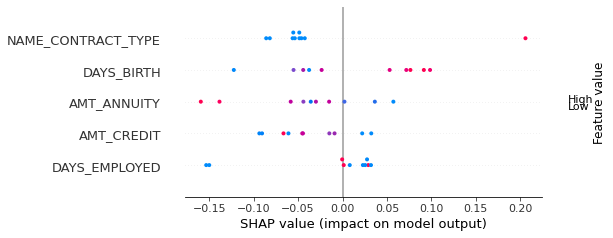

In [113]:
summary_plot(sv[0], X_test.head(10), max_display=5)

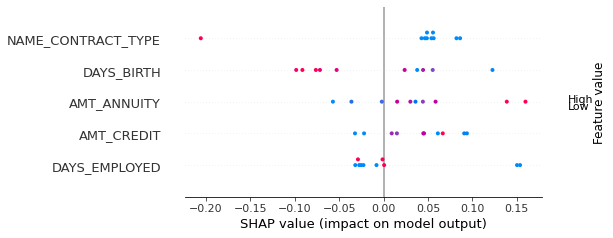

In [114]:
summary_plot(sv[1], X_test.head(10), max_display=5)

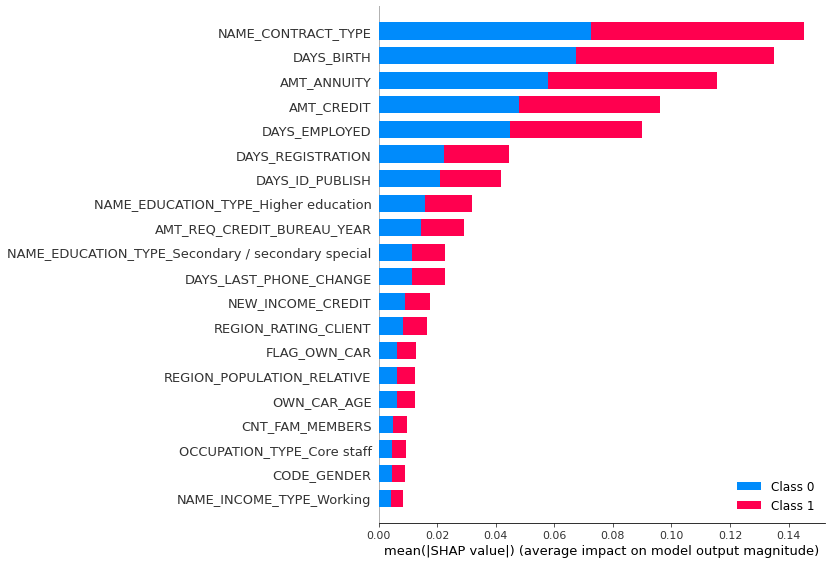

In [115]:
shap.summary_plot(sv, X_test, plot_type = 'bar')

### Grid SearchCV with Gradient Boosting

In [116]:
gboos = GradientBoostingClassifier(max_depth=4, min_samples_split=2, 
                                   min_samples_leaf=1, subsample=1,
                                   max_features='sqrt', random_state=0)

In [117]:
params = {
    'n_estimators' : [90, 100, 110],
    'max_features':["log2", "sqrt"]
    }

In [118]:
f2_score = make_scorer(fbeta_score, beta=2, average='binary')
gs = GridSearchCV(estimator=gboos, param_grid=params, scoring=f2_score, cv=5, n_jobs=-1)

In [119]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=0, subsample=1),
             n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'n_estimators': [90, 100, 110]},
             scoring=make_scorer(fbeta_score, beta=2, average=binary))

In [120]:
gs.best_params_

{'max_features': 'sqrt', 'n_estimators': 100}

In [121]:
gs.best_score_

0.7952834455337552

### Gradient Boost

In [122]:
gb = GradientBoostingClassifier(random_state=0, **gs.best_params_)
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_features='sqrt', random_state=0)

In [123]:
gb.score(X_test, y_test)

0.7578046324269889

### Plot the shap for the Gradient Boost

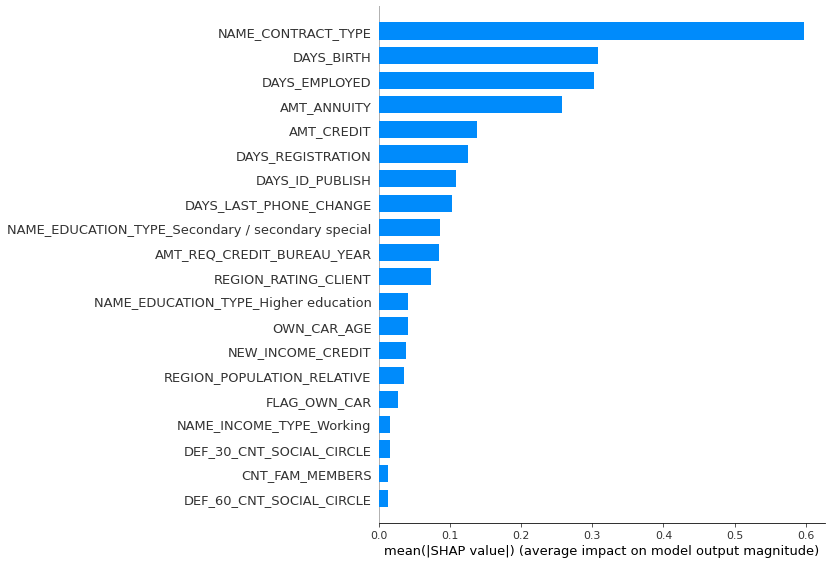

In [124]:
explainer = shap.TreeExplainer(gb)
sv = explainer.shap_values(X_test)
shap.summary_plot(sv, X_test, plot_type = 'bar')

In [125]:
y_pred = gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[3521, 1443],
       [ 962, 4004]])

In [126]:
accuracy=accuracy_score(y_test,y_pred)
Precision=precision_score(y_test, y_pred)
Recall=recall_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred)
print(accuracy)
print(Precision)
print(Recall)
print(f1score)

0.7578046324269889
0.7350835322195705
0.806282722513089
0.7690387016229713


### GridSearchCV with ADaBoost 

In [127]:
Adab = AdaBoostClassifier(random_state=0)

In [128]:
params = {
    'n_estimators' : [100, 110, 120],
    'learning_rate':[1, 1.1] 
    }

In [129]:
f2_score = make_scorer(fbeta_score, beta=2, average='binary')
gs = GridSearchCV(estimator=Adab, param_grid=params, scoring=f2_score, cv=5, n_jobs=-1)

In [130]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [1, 1.1],
                         'n_estimators': [100, 110, 120]},
             scoring=make_scorer(fbeta_score, beta=2, average=binary))

In [131]:
gs.best_params_

{'learning_rate': 1.1, 'n_estimators': 120}

In [132]:
Ab = AdaBoostClassifier(random_state=0, **gs.best_params_)
Ab.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1.1, n_estimators=120, random_state=0)

In [133]:
Ab.score(X_test, y_test)

0.7545820745216516

In [134]:
y_pred = Ab.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[3404, 1560],
       [ 877, 4089]])

In [135]:
accuracy=accuracy_score(y_test,y_pred)
Precision=precision_score(y_test, y_pred)
Recall=recall_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred)
print(accuracy)
print(Precision)
print(Recall)
print(f1score)

0.7545820745216516
0.7238449283058949
0.8233991139750302
0.7704192180876119


### Pipeline

In [136]:
pipeline_lr=Pipeline([('pca1',PCA(n_components=10)),
                     ('lr_classifier',LogisticRegression(random_state=0))])

In [137]:
pipeline_dt=Pipeline([('pca2',PCA(n_components=10)),
                     ('dt_classifier',DecisionTreeClassifier())])

In [138]:
pipeline_randomforest=Pipeline([('pca3',PCA(n_components=10)),
                     ('rf_classifier',RandomForestClassifier())])

In [139]:
pipeline_AdaBoost=Pipeline([('pca4',PCA(n_components=10)),
                     ('Ad_classifier',AdaBoostClassifier())])

In [140]:
pipeline_GradBoost=Pipeline([('pca4',PCA(n_components=10)),
                     ('Gboos_classifier',GradientBoostingClassifier())])

In [141]:
pipeline_svm=Pipeline([('pca5',PCA(n_components=10)),
                     ('SVC_classifier',SVC())])

In [142]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest, pipeline_AdaBoost, pipeline_GradBoost, pipeline_svm]

In [143]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [144]:
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: 'AdaBoost', 
             4: 'Gradient Boosting', 5: 'SVC'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [145]:
for i,model in enumerate(pipelines):
    print("{} Accuracy: {}".format(pipe_dict[i],model.score(X_test,y_test)))

Logistic Regression Accuracy: 0.6699899295065458
Decision Tree Accuracy: 0.5995971802618328
RandomForest Accuracy: 0.6960725075528701
AdaBoost Accuracy: 0.6908358509566969
Gradient Boosting Accuracy: 0.6925478348439074
SVC Accuracy: 0.7011077542799597


In [146]:
data = {'Model': ['Logistic', 'DTree', 'RFC', 'AdaBoost','Gradient Boosting', 'SVC'], 
        'Accuracy': [0.6656, 0.60923, 0.66143, 0.67099, 0.69164, 0.69909]}  
df=pd.DataFrame(data)

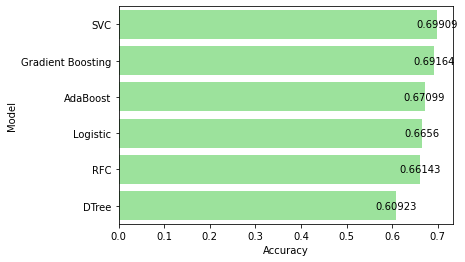

In [147]:
ax=sns.barplot(x="Accuracy",y="Model",color='lightgreen', data=df, order=df.sort_values('Accuracy',ascending = False).Model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")

In [148]:
for i,model in enumerate(pipelines):
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy=model.score(X_test,y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy:SVC


### Using MakePipelines for  RFC

In [149]:
pipe = make_pipeline((RandomForestClassifier()))
grid_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [90, 100, 110],
                 "randomforestclassifier__max_depth":[20, 25, 30],
                 "randomforestclassifier__min_samples_leaf":[1,2,5],
                 "randomforestclassifier__max_leaf_nodes": [2, 5, 10]}]
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0, n_jobs=-1) # Fit grid search
model = gridsearch.fit(X_train,y_train)

In [150]:
model.score(X_test,y_test)

0.7241691842900302

In [151]:
# Fit and predict test class probabilities
y_test_probs =model.predict_proba(X_test)[:,1]

# Containers for f-beta, precision, and recall scores at different prob. thresholds
f1_scores = []
f0_5_scores = []
f2_scores = []
precision_scores = []
recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)

# Find scores for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(2)
        else:
            y_test_preds.append(1)
            
    f1 = f1_score(y_test, y_test_preds, average='macro')
    f0_5 = fbeta_score(y_test, y_test_preds, beta=0.5, average='macro')
    f2 = fbeta_score(y_test, y_test_preds, beta=2, average='macro')
    prec = precision_score(y_test, y_test_preds, average='macro')
    rec = recall_score(y_test, y_test_preds, average='macro')
        
    f1_scores.append(f1)
    f0_5_scores.append(f0_5)
    f2_scores.append(f2)
    precision_scores.append(prec)
    recall_scores.append(rec)

### Plot the graph for the probability Threshold

<Figure size 288x576 with 0 Axes>

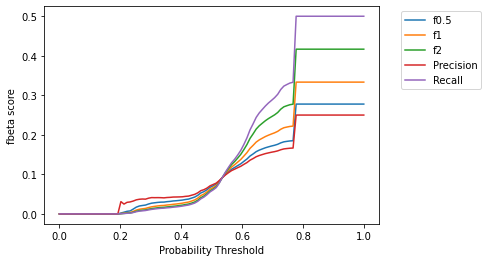

In [152]:
plt.figure(figsize=(4, 8))
fig, ax = plt.subplots()
ax.plot(probability_thresholds, f0_5_scores , label='f0.5')
ax.plot(probability_thresholds, f1_scores, label='f1')
ax.plot(probability_thresholds, f2_scores, label='f2')
ax.plot(probability_thresholds, precision_scores, label='Precision')
ax.plot(probability_thresholds, recall_scores, label='Recall')
ax.set_xlabel('Probability Threshold');
ax.set_ylabel('fbeta score');
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');